<h1>Bi-Classification: Switch Unsafe Wells</h1>
<p><i>Name: Chan Wing Kin, ITSC: wkchanaj, SID:20277087</i></p>
<p>In this question, we are going to explore what determines the decision on switching unsafe wells for arsenic pollution in Bangladesh.</p>
<p>Here is the procedure for conducting the analysis:</p>
<ol>
    <li>Analyze the distribution of data to get intuition of which predictors might be significant.</li>
    <li>Extract possible feature(s) from the original predictors.</li>
    <li>Select attributes by examing the p-value of predictors from Logistic Regression</li>
    <li>Test multiple bi-classification algorithms and optimize hyperparameters to decide the best algorithm for this problem.</li>
    <li>Fine tune the selected algorithm and quantify uncertainties of the selected model</li>
</ol>
<p>Toward the end of the analysis, a model will be selected and its performance will be explored/discussed.</p>

<h2>Import Libraries</h2>

In [1]:
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split 
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import randint
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.api as sm

C:\Users\Henry\Anaconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Henry\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

<h2>Importing data</h2>

In [3]:
data = pd.read_csv('wells.csv', header=0)

In [4]:
data = data.dropna()
print("(Rows, Columns):{0}".format(data.shape))

(Rows, Columns):(6448, 8)


<h2>Predictors</h2>
<p>Here are the predictors provided with descriptions:</p>
<ul>
    <li>distance - the distance to the closest known safe well</li>
    <li>arsenic - the arsenic level of respondent's well</li>
    <li>community - whether any members of the household are active in community organizations</li>
    <li>education - the education level of the head of household</li>
    <li>safe - True if below 0.5 in units of hundreds of micrograms per liter of arsenic level; False otherwise</li>
</ul>
<p>From the above data, it can be seen that all provided predictors's value is encoded with meanings (e.g. Larger the "education" value, more educated the head of household are).</p>
<p>So, it is not necessary to process the discrete predictors to retain the meaning of numbers.</p>

In [5]:
data.head()

,switch,arsenic,unsafe,distance,x,y,community,education
0,True,236,True,1682.600021,260867.531250,2632851.25,0,0
1,True,71,True,4732.199860,260817.375000,2632870.25,0,0
2,False,207,True,2096.699905,260873.781250,2632848.75,0,10
3,True,115,True,2148.600006,260833.000000,2632839.00,0,12
4,True,196,True,3258.200073,260858.328125,2632808.50,1,12


<h2>Data Distribution</h2>

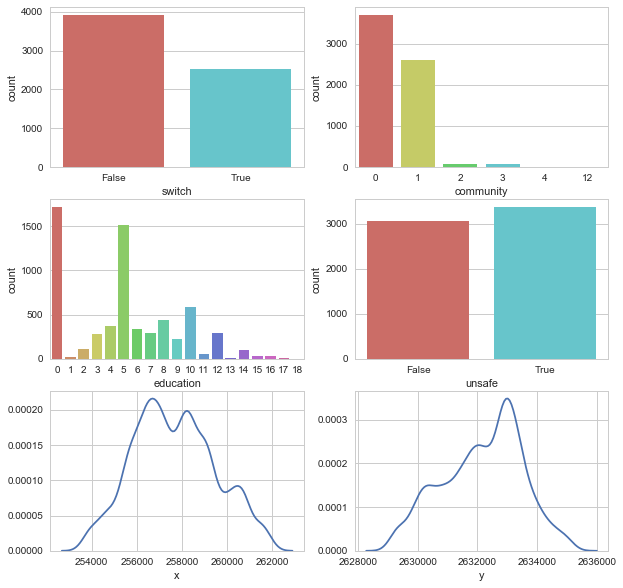

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=3)
sns.countplot(x='switch', data=data, palette='hls', ax=ax[0][0])
sns.countplot(x='community', data=data, palette='hls', ax=ax[0][1])
sns.countplot(x='education', data=data, palette='hls', ax=ax[1][0])
sns.countplot(x='unsafe', data=data, palette='hls', ax=ax[1][1])
sns.distplot(data.x, hist=False, ax=ax[2][0])
sns.distplot(data.y, hist=False, ax=ax[2][1])
plt.show()

<h2>Predictors Analysis and Feature Extraction</h2>
<p><i>There are few observations can be drawn from the plots</i></p>
<ul>
    <li> From the "switch" barchart plot, it can be seen that the data of two class is relatively balanced. </li>
    <li>From the distribution of community, it might be a good idea to divide the community data into two class - (i) has community, and (ii) has no community. </li>
</ul>

In [7]:
data['hasCommunity']=np.where(data['community']>0, True, False)

In [8]:
data.groupby('switch').mean()

,arsenic,unsafe,distance,x,y,community,education,hasCommunity
switch,,,,,,,,
False,56.996175,0.327384,2673.28559,257575.672074,2.632227e+06,0.474248,5.041560,0.436257
True,154.487332,0.828979,3928.57047,257828.774563,2.632106e+06,0.452098,5.068488,0.408947


<p>As means of x, y, community, education and hasCommunity are close for each case, it is suspected that the "switch" is not highly dependent on these attributes. This assumption will be validated below. </p>


In [9]:
data.groupby('switch').std()

,arsenic,unsafe,distance,x,y,community,education,hasCommunity
switch,,,,,,,,
False,81.039688,0.469319,3272.180298,1775.001831,1394.370688,0.634368,3.929636,0.495983
True,125.838748,0.376602,3403.333124,1870.033763,1236.487750,0.698996,4.137304,0.491737


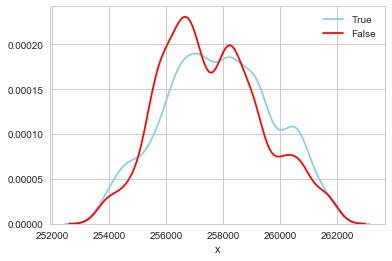

In [10]:
sns.distplot(data[data['switch']==True].x, color="skyblue", hist=False, label="True")
sns.distplot(data[data['switch']==False].x, color="red", hist=False, label="False")
plt.show()

<p>At first glance, there is no clear correlation between "switch" and "x". It is suspected that x might not be a determinal attribute for predicting "switch".</p>

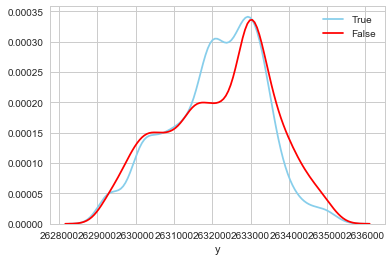

In [11]:
sns.distplot(data[data['switch']==True].y, color="skyblue", hist=False, label="True")
sns.distplot(data[data['switch']==False].y, color="red", hist=False, label="False")
plt.show()

<p>At a certain range of "y", for "switch" equals to True, the occurence of it is much higher than that of "switch" equals to False. It might hint that "y" might show a stronger correlation with "switch" than that of "x". </p>

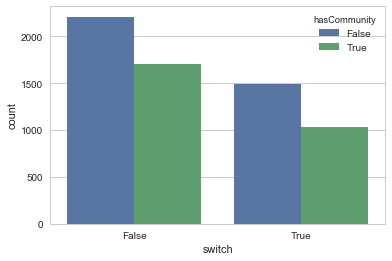

In [12]:
sns.countplot(x="switch", hue="hasCommunity", data=data)
plt.show()

<p>For the distribution shown in the above chart, it displays a weak relation that for "switch" equals to True, it has a higher chance that "hasCommunity" equals to False.</p>

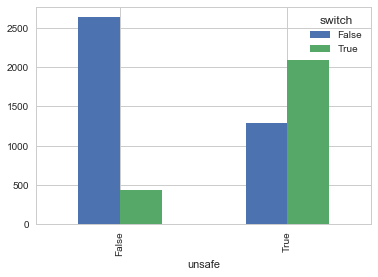

In [13]:
pd.crosstab(data.unsafe, data.switch).plot(kind='bar')
plt.show()

<p> The chart above shows a strong correlation between "switch" and "unsafe". </p>

<h2>Attribute Selection</h2>
<p>In this section, the assumptions above will be tested to find a set of predictors that are useful for predicting "switch".</p>

In [14]:
cols=["distance", "arsenic", "hasCommunity", "unsafe", "x", "y", "community"]
X = data[cols]
y = data.switch

In [15]:
logit_model = sm.Logit(y, X.astype(float))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.526086
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 6448
Model:                          Logit   Df Residuals:                     6441
Method:                           MLE   Df Model:                            6
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                  0.2142
Time:                        23:21:19   Log-Likelihood:                -3392.2
converged:                       True   LL-Null:                       -4317.1
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
distance     -8.045e-05   9.58e-06     -8.400      0.000   -9.92e-05   -6.17e-05
arsenic          0.0046

<p>From p-values of different predictors, a set of predictors with p-value less than 0.05 is selected for predicting the "switch".</p>
<ul>
    <li>distance</li>
    <li>arsenic</li>
    <li>unsafe</li>
    <li>y</li>
</ul>
<p>The final selection aligns with the intuition gained from examining data distribution in the last section.</p>
<p>An interesting observation is that the p-value of "hasCommunity", which is derived from "community", has a significantly lower p-value than that of "community". Although the p-value is much higher than 0.05, it is interesting that the p-value drop significantly for the handcrafted feature.</p>
<p>After testing these features, it is found that "y" deteriorate the performance of the prediction. Hence, "y" is ommitted.</p>

<h2>Model Selection</h2>
<p>A brief search for the best model, using the default parameters provided by the scikit-learn, is done in this section.</p>
<p>The following model will be tested in this section: </p>
<ul>
    <li>QDA</li>
    <li>Logistic Regression</li>
    <li>K Nearest Neighbor</li>
    <li>Multi-layer Perceptron</li>
</ul>
<p>Although using the default parameter could not reflect the best performance offered by each model, the model scanning might provide insight on the expected optimal accuracy of this problem.</p>
<p>The data is randomly split into training(80%) and testing(20%) sets.</p>

In [16]:
cols=['arsenic', 'unsafe', 'distance']
X = data[cols]
y = data.switch

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models=[MLPClassifier, KNeighborsClassifier, LogisticRegression, QDA]

In [18]:
for model in models: 
    classification = model()
    classification.fit(X_train, y_train)
    y_pred = classification.predict(X_test)
    print(model.__name__,':', classification.score(X_test, y_test))

MLPClassifier : 0.6992248062015504
KNeighborsClassifier : 0.7069767441860465
LogisticRegression : 0.7348837209302326
QuadraticDiscriminantAnalysis : 0.7116279069767442


<p>The performance of MLPClassifier is lower than other model significantly. It might due to the fact that MLPClassifier requires fine-tuning of hyperparameter to achieve a desirable result. In the coming section, the performance of models will be optimized through hyperparameter tuning with respect to the AUC score of models.</p>

<h2>Model 1 - Quadratic Discriminant Analysis </h2>
<p><i>Note: QDA has no hyperparameter tuning required. </i></p>

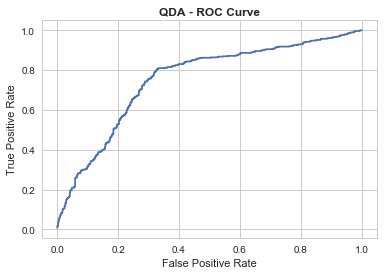

AUC Score: 0.7522801278752128


In [19]:
classification = QDA()
classification.fit(X_train, y_train)
y_pred_score = classification.predict_proba(X_test)
y_pred_prob = [score[1] for score in y_pred_score]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('QDA - ROC Curve', fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(fpr, tpr)
plt.show()
print('AUC Score:' ,auc_score)

<h2>Model 2 - K-Nearest Neighbors </h2>
<p><i>Note: The value of K is tuned to optimize the performance.</i></p>

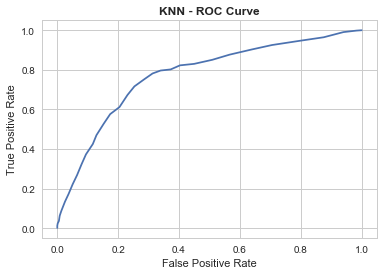

AUC Score: 0.7719377251672671


In [20]:
classification = KNeighborsClassifier(n_neighbors=35)
classification.fit(X_train, y_train)
y_pred_score = classification.predict_proba(X_test)
y_pred_prob = [score[1] for score in y_pred_score]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('KNN - ROC Curve', fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(fpr, tpr)
plt.show()
print('AUC Score:' ,auc_score)

<h2>Model 3 - Logistic Regression </h2>
<p><i>Note: 'l1' and 'l2' penalty was tested to optimize the performance.</i></p>

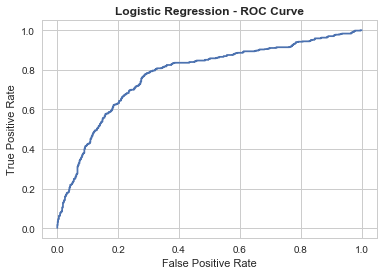

AUC Score: 0.7772266815788432


In [21]:
classification = LogisticRegression(penalty='l2')
classification.fit(X_train, y_train)
y_pred_score = classification.predict_proba(X_test)
y_pred_prob = [score[1] for score in y_pred_score]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Logistic Regression - ROC Curve', fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(fpr, tpr)
plt.show()
print('AUC Score:' ,auc_score)

<h2>Model 4 - Multi-layer Perceptron</h2>
<p><i>Note: Hyperparameter search was conducted to optimize the performance.</i></p>

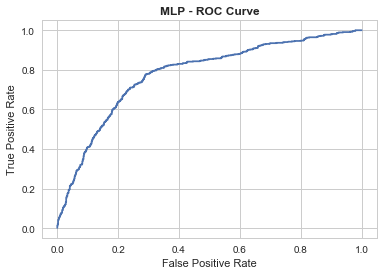

AUC Score: 0.7785851082782376


In [22]:
classification = MLPClassifier(hidden_layer_sizes=(20,5), learning_rate_init=1e-3, learning_rate='invscaling',
                               alpha=1e-3,  random_state=0, max_iter=500, beta_1 = 0.9, beta_2=0.999)
classification.fit(X_train, y_train)
y_pred_score = classification.predict_proba(X_test)
y_pred_prob = [score[1] for score in y_pred_score]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('MLP - ROC Curve', fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(fpr, tpr)
plt.show()
print('AUC Score:' ,auc_score)

<h2>Model Comparison</h2>
<p>Here is the AUC score of tested models:</p>
<ul>
    <li>Quadratic Discriminant Analysis: 0.752</li>
    <li>K-nearest Neighbor: 0.772</li>
    <li>Logistic Regression: 0.777</li>
    <li>Multi-layer Percepton: 0.779</li>
</ul>
<p>From above, the performance of them are rather similar, with MLP providing the best performance.</p>
<p>As logistic regression and MLP provide very similar performance, due to the simiplicity of logistic regression, it is decided to continue the analysis with logistic regression model.</p>

<h2>Dive Deep into Logistic Regression</h2>
<p>In this section, we are going to explore the following:</p>
<ul>
    <li>Classification Accuracy/Error</li>
    <li>Uncertainty of the model</li>
</ul>

In [23]:
cols=['arsenic', 'unsafe', 'distance']
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=0)

<p>Let us exam the ROC curve to determine the threshold for binary classification.</p>

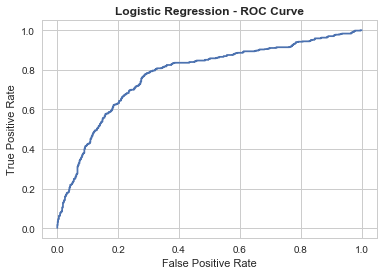

AUC Score: 0.7772266815788432


In [24]:
classification = LogisticRegression(penalty='l2')
classification.fit(X_train, y_train)
y_pred_score = classification.predict_proba(X_test)
y_pred_prob = [score[1] for score in y_pred_score]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Logistic Regression - ROC Curve', fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(fpr, tpr)
plt.show()
print('AUC Score:' ,auc_score)

<p>It can be seen that for True Positive Rate below 0.8, it gain false positive rate at a slower rate. It leads to a decision of using the threshold that leads to True Positive Rate close to 0.8.</p>

In [25]:
INDEX_FOR_THRESHOLD = np.where(tpr==[x for x in tpr if (x<0.81 and x>0.8)][0])[0][0]
threshold = thresholds[INDEX_FOR_THRESHOLD]

In [26]:
#Determine the prediction with the selected threshold
y_pred_threshold = [1 if x>=threshold else 0 for x in y_pred_prob]
accuracy = (sum(y_pred_threshold==y_test)/len(y_test))

In [27]:
metrics.confusion_matrix(y_test, y_pred_threshold)

array([[512, 242],
       [107, 429]], dtype=int64)

<h3>Classification Results</h3>
<p>Here is the confusion matrix:</p>
<p>&nbsp;&nbsp;&nbsp;  True&nbsp;&nbsp;  False</p>
<P>True&nbsp;&nbsp;512&nbsp;242</p>
<p>False&nbsp;&nbsp;107&nbsp;429</p>
<p>Here is the classification result using Logistic Regression with threshold determine from the ROC curve:</p>
<ul>
    <li>Classification Accuracy: 72.9%</li>
    <li>Type I error: 0.32</li>
    <li>Type II error: 0.20</li>
</ul>


<h3>Bootstrap</h3>
<p>In this section, bootstrap method is used to estimate uncertainty of coefficient of fitted logistic regression model.</p>

In [28]:
def classification_coef(index):
    classification = LogisticRegression(penalty='l2')
    classification.fit(X.iloc[index], y[index])
    return classification.intercept_, classification.coef_

In [29]:
coef = []
intercept = []
for i in range(1000):
    new_intercept, new_coef = classification_coef(index=randint(len(X), size=len(X)))
    coef.append(new_coef.tolist()[0])
    intercept.append(new_intercept.tolist()[0])

<p>With the above code, we resample from the training data with replacement for 1000 times to fit the logistic regression model. 
After fitting with the logistic regression model, the coefficients are extracted. 
Their mean and standard deviation is calculated to estimate consistency of the fitted model.</p>
<p>As three predictors are used, there will be three values appeared for coefficients.</p>

In [30]:
print('Intercept [Mean]: ', np.mean(intercept))
print('Intercept [SD]: ', np.std(intercept))
print('Coefficient [Mean]: ', np.mean(coef, axis=0))
print('Coefficient [SD]: ', np.std(coef, axis=0))

Intercept [Mean]:  -1.7597719505642027
Intercept [SD]:  0.052218094479706406
Coefficient [Mean]:  [ 4.60737884e-03  1.89955070e+00 -7.98879847e-05]
Coefficient [SD]:  [4.49379978e-04 9.02269752e-02 9.68271219e-06]


<p>In the above result, it can be observed that the SDs of different coefficients are around 10 times less than that of corresponding means. This indicates the uncertainty of the model is sufficiently small for claiming the stability of logistic regression model on this problem.</p>

<h2>Conclusion</h2>
<p>Data has been explored extensively and it was attempted to extract extra features to improve the model.</p>
<p>After predictor selection by examining p-value, it was determined that (i) arsenic,(ii) unsafe, and (iii) distance are the determining factors for predicting the "switch".</p>
<p>Different models were tested, which showed similar performance after hyperparameter tuning. Logistic Regression was selected due to its performance (i.e. high AUC value) and simplicity when comparing with Multi-layer Perceptron.</p>
<p>To determine the best threshold, the ROC curve was used by finding the spot providing a high true positive rate while having a low false positive rate.</p>
<p>By training the Logistic Regression model with selected predictors and selecting a suitable threshold, an accuracy of 72.9% was achieved, and the bootstrap result indicates the stability of the model with this dataset.</p>
<p>Further investigation can be conducted to improve the performance by providing other information or crafting extra features with domain knowledge.</p>